In [1]:
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torchvision
from torchvision import transforms as T

import os
from typing import final
from pathlib import Path
from IPython.display import clear_output
from pathlib import Path
from PIL import Image

import numpy as np
import numpy.typing as npt
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
@final
class Animals(Dataset):
    def __init__(self, path: str | Path, train: bool, transform):
        self.path = Path(path)
        self.train = train
        self.transform = transform

        self.files_list = []
        if train:
            train_path = self.path / "train" / "train"
            self.class_to_idx = {}
            self.classes = []
            for i, animal in enumerate(os.listdir(train_path)):
                self.class_to_idx[animal] = i
                self.classes.append(animal)

                for file in os.listdir(train_path / animal):
                    self.files_list.append(train_path / animal / file)

        else:
            self.class_to_idx = None
            self.classes = None
            test_path = self.path / "test" / "test"
            for file in os.listdir(test_path):
                self.files_list.append(test_path / file)
            
    
    def __getitem__(self, i: int):
        file_path = self.files_list[i]
        image = Image.open(file_path).convert("RGB")
        image = self.transform(image)
        
        if self.train:
            class_name = file_path.parent.name
            label = self.class_to_idx[class_name]
            return image, label
        else:
            return image, str(file_path.name)

    def __len__(self):
        return len(self.files_list)

In [3]:
import timm

model = timm.create_model(
    'mobilenetv3_large_100.miil_in21k_ft_in1k',
    pretrained=True,
    num_classes=10,
)

data_config = timm.data.resolve_model_data_config(model)
train_transform = timm.data.create_transform(**data_config, is_training=True)
test_transform = timm.data.create_transform(**data_config, is_training=False)

In [4]:
full_train_dataset = Animals("./animal-classification-urfu/", train=True, transform=train_transform)
train_len = int(len(full_train_dataset) * 0.8)
val_len = len(full_train_dataset) - train_len
train_dataset, val_dataset = random_split(full_train_dataset, [train_len, val_len])
val_dataset.transform = test_transform

test_dataset = Animals("./animal-classification-urfu/", train=False, transform=test_transform)

In [5]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE)
test_loader = DataLoader(test_dataset, BATCH_SIZE)

In [6]:
from dataclasses import dataclass, field
from matplotlib import pyplot as plt

@dataclass
class AccLossLog:
    acc: float
    loss: float

@dataclass
class History:
    train: list[AccLossLog] = field(default_factory=list)
    test: list[AccLossLog] = field(default_factory=list)

    def append(self, train_log: AccLossLog, test_log: AccLossLog):
        self.train.append(train_log)
        self.test.append(test_log)
        assert len(self.train) == len(self.test)

    def __len__(self):
        return len(self.train)

    def get_train_accs(self):
        return [log.acc for log in self.train]

    def get_test_accs(self):
        return [log.acc for log in self.test]

    def get_train_losses(self):
        return [log.loss for log in self.train]

    def get_test_losses(self):
        return [log.loss for log in self.test]

    def plot(self):
        """Строит графики точности и loss для train и test"""
        epochs = range(1, len(self) + 1)
        plt.figure(figsize=(12,5))

        # Accuracy
        plt.subplot(1,2,1)
        plt.plot(epochs, self.get_train_accs(), 'b-', label='Train Acc')
        plt.plot(epochs, self.get_test_accs(), 'r-', label='Test Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy per Epoch')
        plt.legend()

        # Loss
        plt.subplot(1,2,2)
        plt.plot(epochs, self.get_train_losses(), 'b-', label='Train Loss')
        plt.plot(epochs, self.get_test_losses(), 'r-', label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()

In [7]:
from tqdm.auto import tqdm

def accuracy(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    correct = (y_pred == y_true).float()
    return (correct.sum() / len(correct)).item()

def do_train_step(
    model: nn.Module,
    train_loader: DataLoader[torch.Tensor],
    loss_fn: nn.Module,
    optim: torch.optim.Optimizer,
    device: str
) -> tuple[float, float]:
    model = model.to(device)
    model.train()
    
    train_loss = train_acc = 0
    with tqdm(train_loader, desc="Train", leave=False) as train_bar:
        for X, y in train_bar:
            X, y = X.to(device), y.to(device)

            optim.zero_grad()
    
            out = model(X)
            pred = out.argmax(dim=1)
        
            loss = loss_fn(out, y)
        
            loss.backward()
            optim.step()
        
            train_loss += loss.item()
            train_acc += accuracy(pred, y)
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    return train_acc, train_loss

@torch.inference_mode()
def do_test_step(
    model: nn.Module,  
    test_loader: DataLoader[torch.Tensor],
    loss_fn: nn.Module,
    device: str
) -> tuple[float, float]:
    model = model.to(device)
    model.eval()

    test_loss = test_acc = 0
    with tqdm(test_loader, desc="Test", leave=False) as test_bar:
        for X, y in test_bar:
            X, y = X.to(device), y.to(device)
    
            out = model(X)
            pred = out.argmax(dim=1)
            
            loss = loss_fn(out, y)
    
            test_loss += loss.item()
            test_acc += accuracy(pred, y)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    return test_acc, test_loss

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    optim: torch.optim.Optimizer,
    loss_fn: nn.Module,
    epochs: int,
    device: str,
    history: History | None = None
) -> History:
    if not history:
        history = History()

    for epoch in tqdm(range(epochs), desc="Epochs"):
        train = AccLossLog(*do_train_step(model, train_loader, loss_fn, optim, device))
        test = AccLossLog(*do_test_step(model, test_loader, loss_fn, device))
        history.append(train, test)
        
        clear_output(wait=True)

        history.plot()

    return history

In [8]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                        Param #
MobileNetV3                                   --
├─Conv2d: 1-1                                 432
├─BatchNormAct2d: 1-2                         32
│    └─Identity: 2-1                          --
│    └─Hardswish: 2-2                         --
├─Sequential: 1-3                             --
│    └─Sequential: 2-3                        --
│    │    └─DepthwiseSeparableConv: 3-1       464
│    └─Sequential: 2-4                        --
│    │    └─InvertedResidual: 3-2             3,440
│    │    └─InvertedResidual: 3-3             4,440
│    └─Sequential: 2-5                        --
│    │    └─InvertedResidual: 3-4             10,328
│    │    └─InvertedResidual: 3-5             20,992
│    │    └─InvertedResidual: 3-6             20,992
│    └─Sequential: 2-6                        --
│    │    └─InvertedResidual: 3-7             32,080
│    │    └─InvertedResidual: 3-8             34,760
│    │    └─InvertedResidual: 3-9   

In [9]:
torch.set_grad_enabled(True)
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [10]:
loss_fn = nn.CrossEntropyLoss()

optim = torch.optim.AdamW(params=model.parameters(), lr=1e-3)

history = History()

epochs = 10

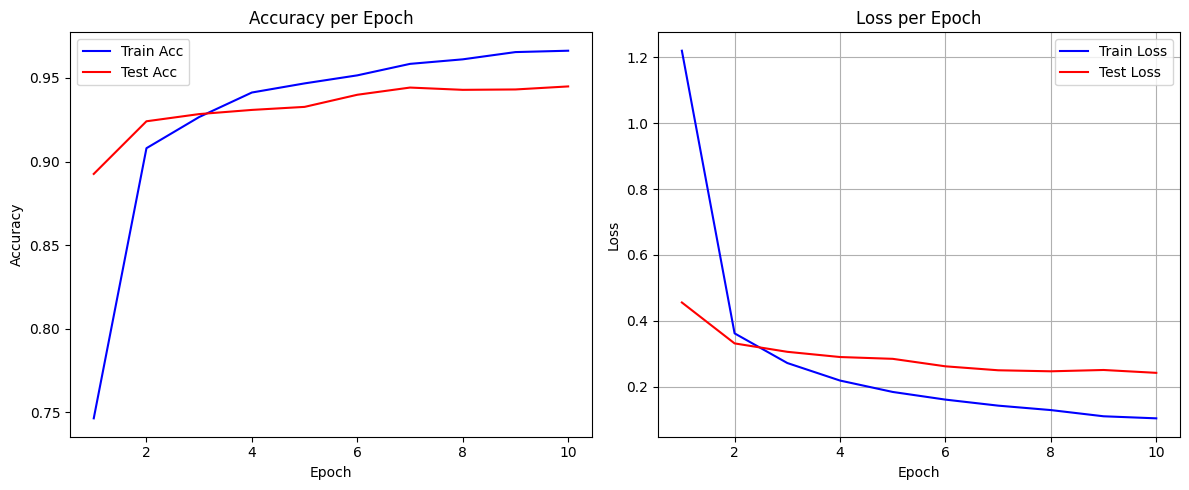

In [11]:
history = train_model(model, train_loader, val_loader, optim, loss_fn, epochs, device, history)

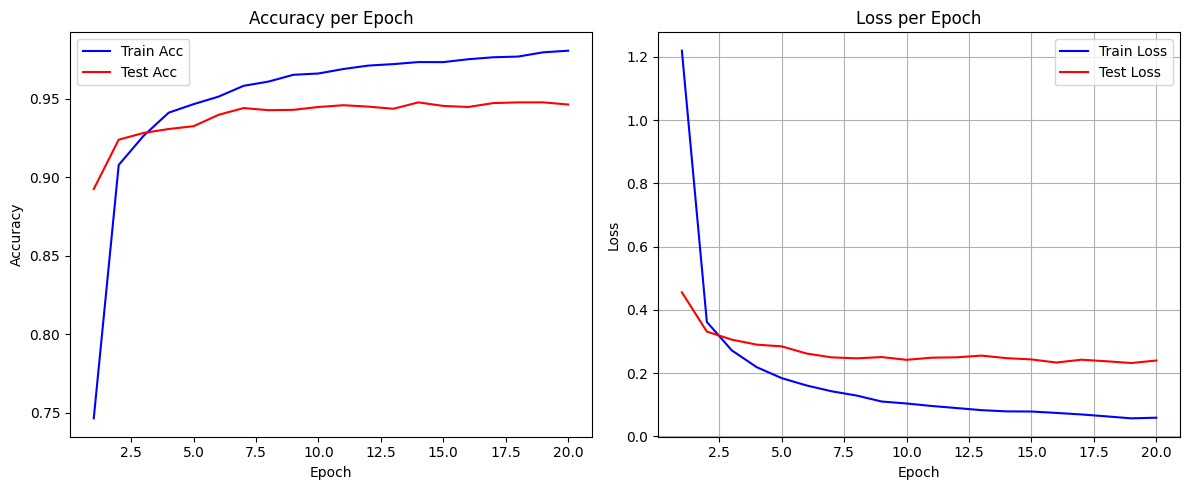

In [12]:
optim.lr = 1e-4
epochs = 10
history = train_model(model, train_loader, val_loader, optim, loss_fn, epochs, device, history)

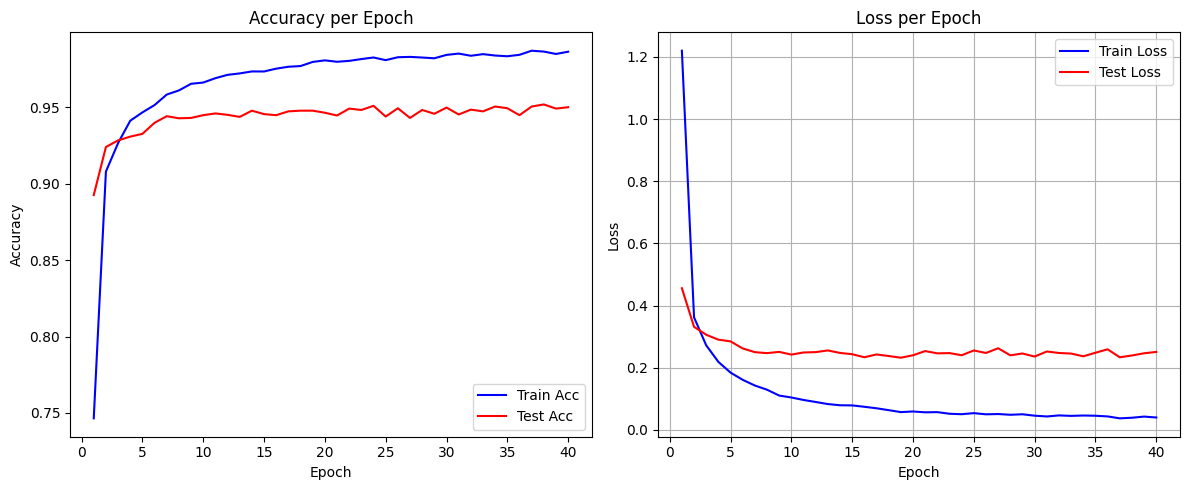

In [13]:
optim.lr = 1e-5
epochs = 20
history = train_model(model, train_loader, val_loader, optim, loss_fn, epochs, device, history)

In [13]:
do_test_step(model, val_loader, loss_fn, device)

Test:   0%|          | 0/138 [00:00<?, ?it/s]

(0.8640549519787664, 0.44824344041230885)

In [ ]:
torch.save(model.state_dict(), "95acc.pt")

In [12]:
model = timm.create_model(
    'mobilenetv3_large_100.miil_in21k_ft_in1k',
    pretrained=True,
    num_classes=10,
)
model.load_state_dict(torch.load("./95acc.pt"))

<All keys matched successfully>

In [14]:
# ответы нейросети и правильные ответы перепутались
true_label_map = {
    'cat': 0,
    'elephant': 1,
    'butterfly': 2,
    'sheep': 3,
    'spider': 4,
    'horse': 5,
    'dog': 6,
    'cow': 7,
    'chicken': 8,
    'squirrel': 9,
}

index_remap = {i: true_label_map[name] for name, i in full_train_dataset.class_to_idx.items()}
print(index_remap)

{0: 1, 1: 0, 2: 8, 3: 4, 4: 7, 5: 2, 6: 5, 7: 6, 8: 3, 9: 9}


In [15]:
model = model.to(device)
model.eval()

ids = []
labels = []

with torch.inference_mode():
    for X, file_name in tqdm(test_loader, desc="Predict"):
        X = X.to(device)
        pred = model(X).argmax(dim=1).cpu().numpy()
        ids.extend(file_name)
        labels.extend(index_remap[p] for p in pred)

results = pd.DataFrame({
    "id": ids,
    "label": labels
})
results

Predict:   0%|          | 0/77 [00:00<?, ?it/s]

,id,label
0,OIP-zoUAGfrpjJabe0T5ISlb1gHaFK.jpeg,5
1,OIP-YBfm8KLGbabzJ9Vqwx0s1wHaEy.jpeg,2
2,OIP-yXvYry0Az3Hy1heAsRR4QQHaFj.jpeg,4
3,OIP-XiuFqxWmyXHxc7f-hA_bCgHaE7.jpeg,4
4,OIP-znXahZn3E2pmOZK_8P6g6wHaGR.jpeg,5
...,...,...
2435,OIP-WyZzzmbtt1h3g9cyvobW6AHaIR.jpeg,4
2436,OIP-ZfszJaCz24S4kkco14XTeQHaGA.jpeg,1
2437,OIP-xf8n1B_teLq_I2S03QmjRAHaH5.jpeg,3
2438,OIP-z-Di2tlPDdinq2kU19r-CQHaFN.jpeg,4


In [16]:
results.to_csv("Mishin_Timofey.csv", index=False)